In [46]:
import os
import re
import matplotlib.pyplot as plt
from utils.imutil import *
from utils.list_all_files import *
from utils.crop import *
from utils.progress import *
from utils.mosaic import *
from utils.draw_shapes import *

import ujson
import numpy as np

In [57]:
input_dir = '../data/openface+microsoft/json'

In [58]:
json_filenames = list(list_all_files(input_dir))

In [79]:
filenames = []
reps = []
rects = []
ages = []
genders = []

for fn in progress(json_filenames):
    with open(fn) as f:
        try:
            data = ujson.load(f)
        except:
            print(f.read())
            break
        
    for face in data['facesFromOpenFace']:
        try:
            rects.append([face[key] for key in 'YBXR'])
            reps.append(face['rep'])
            ages.append(face['age'])
            genders.append(face['gender'])
            filenames.append(data['imageName'])
        except KeyError:
            pass

59278 0:00:12 5020.44/s


In [160]:
n_categories = 20
age_limits = []
for pct in np.linspace(0, 100, n_categories+1):
    if pct == 0:
        continue
    limit = np.percentile(ages, pct)
    age_limits.append(limit)

In [161]:
age_limits

[6.099999904632568,
 11.899999618530273,
 17.700000762939453,
 22.100000381469727,
 25.100000381469727,
 27.299999237060547,
 29.0,
 30.600000381469727,
 32.20000076293945,
 33.79999923706055,
 35.599998474121094,
 37.5,
 39.599998474121094,
 41.79999923706055,
 44.20000076293945,
 47.099998474121094,
 50.70000076293945,
 56.0,
 65.0999984741211,
 95.30000305175781]

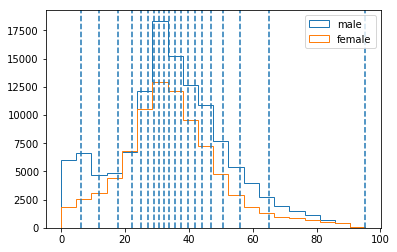

In [162]:
plt.hist([age for age,gender in zip(ages, genders) if gender == 'male'], bins=20, histtype='step', label='male')
plt.hist([age for age,gender in zip(ages, genders) if gender == 'female'], bins=20, histtype='step', label='female')
for age in age_limits:
    plt.axvline(age, linestyle='--')
plt.legend()
plt.show()

In [163]:
def natural_sort_key(s, _nsre=re.compile('([0-9]+)')):
    return [int(text) if text.isdigit() else text.lower()
            for text in _nsre.split(s)]

faces_packed = list(zip(filenames, reps, rects, ages, genders))
faces_packed.sort(key=lambda e: natural_sort_key(e[0]))
filenames, reps, rects, ages, genders = zip(*faces_packed)

In [164]:
age_categories = []
for age in ages:
    for i, limit in enumerate(age_limits):
        if age <= limit:
            age_categories.append(i)
            break

In [165]:
ages[:3], age_categories[:3]

((31.899999618530273, 34.599998474121094, 36.099998474121094), [8, 10, 11])

In [263]:
onehots = np.zeros((len(filenames), 2 + len(age_limits)), dtype=np.float32)
gender_age_categories = []

In [264]:
for i, (gender, age_category) in enumerate(zip(genders, age_categories)):
    category = age_category
    if gender == 'male':
        onehots[i, 0] = 1
    elif gender == 'female':
        onehots[i, 1] = 1
        category *= 2
    onehots[i, age_category+2] = 1
    gender_age_categories.append(category)

In [265]:
np.save('../data/openface+microsoft/npy32/gender-age.npy', np.asarray(onehots).astype(np.float32))
np.save('../data/openface+microsoft/npy32/gender-age-categories.npy', np.asarray(gender_age_categories).astype(np.int64))

In [183]:
np.save('../data/openface+microsoft/npy32/openface-descriptors.npy', np.asarray(reps).astype(np.float32))

In [238]:
output_side = 32
# output_dtype = np.uint8

def job(task):
    try:
        fn, rect = task
        fn = '../data/photos/png1600/' + fn
        
        # rects were computed on 800x800 images
        n,s,w,e = (np.asarray(rect) * 2).astype(int)
        
        # force it square
        rows = s - n
        cols = e - w
        side = min(rows, cols)
        s = n + side
        e = w + side
        
        img = imread(fn)
        
        face_img = safe_crop(img, n, s, w, e, fill=0)
        face_img = imresize(face_img, max_side=output_side)
        
        return face_img
    
    except:
        raise

results = progress_parallel(job, list(zip(filenames, rects)))

209355 0:12:19 283.27/s


In [239]:
np.save('../data/openface+microsoft/npy32/images.npy', np.asarray(results).astype(np.uint8))

In [258]:
# for i in np.random.randint(0, len(filenames), size=(4,)):
#     imshow(results[i], zoom=4)
#     print(genders[i])
#     print(ages[i])